# ***1. DEPENDENCIES***

In [1]:
# ==============================================================================
# SECTION 1: SETUP AND DEPENDENCIES (UNCHANGED)
# ==============================================================================

# Import all required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

print("TensorFlow version:", tf.__version__)
print("Optuna version:", optuna.__version__)

C:\Users\paulo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow version: 2.15.1
Optuna version: 4.5.0


# ***2. Multiclass model Synthetic Balanced data***

## 2.1. Data loading and pre processing (Split Train 70% Test 30%)

In [2]:

# Print the TensorFlow version to confirm installation
print("TensorFlow version:", tf.__version__)

# Read the combined CSV file into a pandas DataFrame
file_path = "VirtualPatientModels_tGANsynthDatacombined_Final_Balanced_Dis.csv"
try:
    df = pd.read_csv(file_path)
    print(f"'{file_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: '{file_path}' not found. Please check the file path.")
    exit()

# Display all columns without truncation for better viewing
pd.set_option('display.max_columns', None)
display(df.head())
print("\nDataFrame Information:")
df.info()

# Exclude irrelevant columns before pre-processing
# We keep 'part_id' for the data split, and remove the others.
cols_to_exclude_from_features = ['clinical_visit', 'q_date']
df = df.drop(columns=cols_to_exclude_from_features, errors='ignore')

# Identify numerical, categorical, and boolean columns to process
numerical_cols = ['bmi_score', 'gait_get_up', 'bmi_body_fat', 'raise_chair_time', 'waist']

categorical_cols = ['comorbidities_count',
                    'comorbidities_most_important',
                    'iadl_grade',
                    'social_phone',
                    'life_quality',
                    'age',
                    'low_physical_activity',
                    'ortho_hypotension',
                    'gender',
                    'health_rate_comparison',
                    'comorbidities_significant_count',
                    'social_calls',
                    'depression_total_score',
                    'sleep',
                    'house_suitable_participant',
                    'balance_single',
                    'weight_loss',
                    'stairs_number',
                    'memory_complain',
                    'living_alone',
                    'alcohol_units',
                    'leisure_out',
                    'social_text',
                    'house_suitable_professional',
                    #'health_rate',
                    'hospitalization_three_years',
                    'health_rate']	

boolean_cols = ['gait_optional_binary']

columns_to_encode = categorical_cols + boolean_cols

## One-Hot Encoding
print("\nPerforming one-hot encoding on categorical and boolean columns...")
df = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode, dtype=int)
print("DataFrame after one-hot encoding:")
display(df.head())

## Normalize Numerical Columns (Min-Max Scaling)
print("\nStatistics before normalization:")
print(df[numerical_cols].describe())

def normalize(df, cols):
    """Applies Min-Max normalization to specified columns."""
    for col in cols:
        if col not in df.columns:
            print(f"[WARNING] {col} not found in DataFrame.")
            continue
        if df[col].max() != df[col].min():
            df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

df = normalize(df, numerical_cols)

print("\nStatistics after normalization:")
print(df[numerical_cols].describe())

# Save the pre-processed data to be used in the next script
output_file = 'Processed_Combined_Data_OMC_Final_Balanced_Dis.csv'
df.to_csv(output_file, index=False)
print(f"\nProcessed DataFrame saved to '{output_file}'")

TensorFlow version: 2.15.1
'VirtualPatientModels_tGANsynthDatacombined_Final_Balanced_Dis.csv' loaded successfully.


,part_id,clinical_visit,bmi_score,gait_get_up,bmi_body_fat,raise_chair_time,waist,leisure_out,balance_single,stairs_number,gender,sleep,house_suitable_professional,alcohol_units,comorbidities_most_important,memory_complain,house_suitable_participant,social_calls,comorbidities_significant_count,depression_total_score,weight_loss,gait_optional_binary,hospitalization_three_years,iadl_grade,living_alone,life_quality,age,social_phone,health_rate,q_date,comorbidities_count,low_physical_activity,health_rate_comparison,social_text,ortho_hypotension
0,1084,1,24.095500,9.05,22.8,14.00,89.0,7,>5 sec,17.0,M,No sleep problem,Yes,1.5,Non of the above,No,Yes,7,2,2,No,False,0,29,No,6.8,78,180,4 - Good,2016-10-05T22:52:28.000Z,6,No,3 - About the same,0,No
1,1084,2,24.205693,10.30,23.7,13.46,89.0,7,>5 sec,17.0,M,No sleep problem,Yes,21.0,Non of the above,No,Yes,7,0,2,No,False,0,25,No,7.2,79,70,4 - Good,2017-07-20T00:00:00.000Z,7,No,3 - About the same,20,No
2,1084,3,24.576145,9.40,23.2,13.40,89.0,7,>5 sec,0.0,M,No sleep problem,Yes,14.0,Non of the above,No,Yes,4,0,2,No,False,0,24,No,6.5,79,120,4 - Good,2017-12-01T00:00:00.000Z,7,No,3 - About the same,5,No
3,1084,4,24.836407,9.20,23.2,14.10,89.0,8,>5 sec,0.0,M,Occasional sleep problem,Yes,18.0,Non of the above,No,Yes,5,0,3,No,False,0,26,No,6.9,80,120,4 - Good,2018-09-24T00:00:00.000Z,8,No,3 - About the same,0,No
4,1085,1,23.437500,9.80,26.8,16.00,96.0,7,>5 sec,12.0,F,Occasional sleep problem,Yes,0.0,Non of the above,Yes,Yes,7,1,2,No,False,3,31,No,7.3,72,6,4 - Good,2016-10-10T15:04:04.000Z,11,No,3 - About the same,15,No



DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16021 entries, 0 to 16020
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   part_id                          16021 non-null  int64  
 1   clinical_visit                   16021 non-null  int64  
 2   bmi_score                        16021 non-null  float64
 3   gait_get_up                      16021 non-null  float64
 4   bmi_body_fat                     16021 non-null  float64
 5   raise_chair_time                 16021 non-null  float64
 6   waist                            16021 non-null  float64
 7   leisure_out                      16021 non-null  int64  
 8   balance_single                   16021 non-null  object 
 9   stairs_number                    16021 non-null  float64
 10  gender                           16021 non-null  object 
 11  sleep                            16021 non-null  object 

,part_id,bmi_score,gait_get_up,bmi_body_fat,raise_chair_time,waist,comorbidities_count_0,comorbidities_count_1,comorbidities_count_2,comorbidities_count_3,comorbidities_count_4,comorbidities_count_5,comorbidities_count_6,comorbidities_count_7,comorbidities_count_8,comorbidities_count_9,comorbidities_count_10,comorbidities_count_11,comorbidities_count_12,comorbidities_count_13,comorbidities_count_14,comorbidities_count_15,comorbidities_most_important_MCI,comorbidities_most_important_Non of the above,comorbidities_most_important_Osteoporosis if woman /Osteoarthritis if man,comorbidities_most_important_Prior stroke,iadl_grade_19,iadl_grade_20,iadl_grade_21,iadl_grade_22,iadl_grade_23,iadl_grade_24,iadl_grade_25,iadl_grade_26,iadl_grade_27,iadl_grade_28,iadl_grade_29,iadl_grade_30,iadl_grade_31,social_phone_3,social_phone_5,social_phone_6,social_phone_7,social_phone_10,social_phone_14,social_phone_15,social_phone_20,social_phone_21,social_phone_25,social_phone_30,social_phone_35,social_phone_40,social_phone_45,social_phone_50,social_phone_60,social_phone_70,social_phone_75,social_phone_80,social_phone_90,social_phone_120,social_phone_140,social_phone_180,social_phone_200,social_phone_210,social_phone_240,social_phone_250,social_phone_300,social_phone_315,social_phone_360,social_phone_400,social_phone_420,social_phone_480,social_phone_500,social_phone_540,social_phone_560,social_phone_600,social_phone_660,social_phone_700,social_phone_999,social_phone_1200,social_phone_1260,social_phone_2000,life_quality_2.0,life_quality_3.7,life_quality_4.3,life_quality_4.5,life_quality_5.0,life_quality_5.4,life_quality_5.8,life_quality_5.9,life_quality_6.1,life_quality_6.5,life_quality_6.8,life_quality_6.9,life_quality_7.0,life_quality_7.2,life_quality_7.3,life_quality_7.4,life_quality_7.5,life_quality_7.7,life_quality_7.8,life_quality_8.0,life_quality_8.1,life_quality_8.2,life_quality_8.3,life_quality_8.4,life_quality_8.5,life_quality_8.6,life_quality_8.7,life_quality_8.8,life_quality_9.0,life_quality_9.2,life_quality_9.3,life_quality_9.4,life_quality_9.7,life_quality_10.0,age_70,age_71,age_72,age_73,age_74,age_75,age_76,age_77,age_78,age_79,age_80,age_81,age_82,age_83,age_84,age_85,low_physical_activity_No,low_physical_activity_Yes,ortho_hypotension_No,ortho_hypotension_Yes,gender_F,gender_M,health_rate_comparison_2 - A little worse,health_rate_comparison_3 - About the same,health_rate_comparison_4 - A little better,health_rate_comparison_5 - A lot better,comorbidities_significant_count_0,comorbidities_significant_count_1,comorbidities_significant_count_2,social_calls_1,social_calls_3,social_calls_4,social_calls_5,social_calls_6,social_calls_7,social_calls_8,social_calls_10,social_calls_12,social_calls_14,social_calls_15,social_calls_20,social_calls_25,social_calls_30,social_calls_40,social_calls_50,social_calls_70,depression_total_score_0,depression_total_score_1,depression_total_score_2,depression_total_score_3,depression_total_score_4,depression_total_score_5,depression_total_score_6,depression_total_score_7,depression_total_score_8,sleep_No sleep problem,sleep_Occasional sleep problem,sleep_Permanent sleep problem,house_suitable_participant_No,house_suitable_participant_Yes,balance_single_<5 sec,balance_single_>5 sec,balance_single_test non realizable,weight_loss_No,weight_loss_Yes,stairs_number_0.0,stairs_number_2.0,stairs_number_4.0,stairs_number_5.0,stairs_number_12.0,stairs_number_17.0,stairs_number_19.0,memory_complain_No,memory_complain_Yes,living_alone_No,living_alone_Yes,alcohol_units_0.0,alcohol_units_1.0,alcohol_units_1.5,alcohol_units_2.0,alcohol_units_3.0,alcohol_units_4.0,alcohol_units_4.5,alcohol_units_5.0,alcohol_units_6.0,alcohol_units_12.0,alcohol_units_14.0,alcohol_units_18.0,alcohol_units_20.0,alcohol_units_21.0,alcohol_units_63.0,leisure_out_2,leisure_out_3,leisure_out_4,leisure_out_5,leisure_out_6,leisure_out_7,leisure_out_8,leisure_out_10,leisure_out_12,leisure_out_14,leisure_out_20,social_text_0,social_text_1,social_t


Statistics before normalization:
          bmi_score   gait_get_up  bmi_body_fat  raise_chair_time  \
count  16021.000000  16021.000000  16021.000000      16021.000000   
mean      32.936481     15.582787     30.690311        207.580240   
std        7.207275      7.807313      4.408113        366.415984   
min       22.479339      4.000000     19.700000          6.900000   
25%       26.425245      8.983882     27.350683          7.298463   
50%       30.775970     12.434879     30.499514         10.766644   
75%       40.901165     20.924805     35.323420        124.634544   
max       44.658044     34.700000     37.200000        999.000000   

              waist  
count  16021.000000  
mean     106.199893  
std       12.457073  
min       82.000000  
25%       95.762620  
50%      103.000260  
75%      118.742250  
max      134.000000  

Statistics after normalization:
          bmi_score   gait_get_up  bmi_body_fat  raise_chair_time  \
count  16021.000000  16021.000000  16021.000

In [3]:


# ==============================================================================
# SECTION 2: DATA LOADING AND PRE-PROCESSING (MODIFIED Test Set 3)
# ==============================================================================

print("\n" + "="*80)
print("STARTING MULTICLASS CLASSIFICATION (70% SYNTHETIC TRAIN / 30% SYNTHETIC TEST)")
print("="*80 + "\n")

# Reload processed data from the previous script
output_file = 'Processed_Combined_Data_OMC_Final_Balanced_Dis.csv'
try:
    df = pd.read_csv(output_file)
    print(f"'{output_file}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: '{output_file}' not found. Please run the first script to generate the file.")
    exit()

# --- Data Separation ---
df_original = df[df['part_id'] < 3000].copy() 
df_synthetic_full = df[df['part_id'] >= 3000].copy() 

target_columns = [col for col in df.columns if col.startswith('health_rate_') and not col.startswith('health_rate_comparison_')]

# Add class column for stratification
df_synthetic_full['health_rate_class'] = df_synthetic_full[target_columns].idxmax(axis=1)


# ----------------------------------------------------------------------------------
#  TRAINING LOGIC: 70% Stratified Sample of Synthetic Data
# ----------------------------------------------------------------------------------
TRAIN_FRACTION = 0.7
TEST_FRACTION = 0.3 

# Use StratifiedShuffleSplit to get indices for 70% train and 30% test split from synthetic data
sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_FRACTION, random_state=42)

for train_index, test_index in sss.split(df_synthetic_full, df_synthetic_full['health_rate_class']):
    # df_train becomes 70% of the synthetic data
    df_train = df_synthetic_full.iloc[train_index].copy()
    # df_test_synthetic becomes the remaining 30% of the synthetic data (Test Set 2)
    df_test_synthetic = df_synthetic_full.iloc[test_index].copy()

# Drop the helper column from the final train set
df_train = df_train.drop(columns=['health_rate_class'])


# ----------------------------------------------------------------------------------
#  TEST SETS DEFINITION (The 3 Evaluation Sets)
# ----------------------------------------------------------------------------------

# Test Set 1: All Real Data (100% of df_original)
df_test_real_all = df_original.copy()


# Test Set 2: Synthetic Data (30% Split from SSS above) 
# The helper column is still needed here for extraction, drop it later.


# --- Test Set 3: Combined Data Sample (Test Set 1 + Test Set 2) ---
# Concatenate the 30% synthetic test data (df_test_synthetic) and all real data (df_test_real_all)
# Note: We must ensure df_test_real_all also has the 'health_rate_class' helper column for concatenation
df_test_real_all['health_rate_class'] = df_test_real_all[target_columns].idxmax(axis=1)

# Concatenate the two dataframes to create the combined test set
df_test_combined = pd.concat([df_test_real_all, df_test_synthetic], ignore_index=True)


# --- Final Cleanup ---
# Drop the helper column from all test sets where it's not the target column
df_test_synthetic = df_test_synthetic.drop(columns=['health_rate_class']) 
df_test_real_all = df_test_real_all.drop(columns=['health_rate_class'])
df_test_combined = df_test_combined.drop(columns=['health_rate_class'])


print("\n" + "-"*40)
print("FINAL DATASET SHAPES")
print("-" * 40)
print(f"Final training data shape (70% Synthetic): {df_train.shape}")
print(f"Test Set 1 (All Real Data) shape: {df_test_real_all.shape}")
print(f"Test Set 2 (Synthetic ONLY - 30% Never Seen) shape: {df_test_synthetic.shape}")
print(f"Test Set 3 (Combined Test Data: T1 + T2) shape: {df_test_combined.shape}")
print("-" * 40 + "\n")


STARTING MULTICLASS CLASSIFICATION (70% SYNTHETIC TRAIN / 30% SYNTHETIC TEST)

'Processed_Combined_Data_OMC_Final_Balanced_Dis.csv' loaded successfully.

----------------------------------------
FINAL DATASET SHAPES
----------------------------------------
Final training data shape (70% Synthetic): (11132, 245)
Test Set 1 (All Real Data) shape: (117, 245)
Test Set 2 (Synthetic ONLY - 30% Never Seen) shape: (4772, 245)
Test Set 3 (Combined Test Data: T1 + T2) shape: (4889, 245)
----------------------------------------



# 2.2. Feature/Label Extraction (Encoder)

In [4]:

# --- Feature/Label Extraction for ALL Sets ---
feature_columns = df.columns.drop(target_columns + ['part_id'])
x_train = df_train[feature_columns].values
y_train_df = df_train[target_columns].idxmax(axis=1)

# Test Set 1: All Real Data
x_test_real_all = df_test_real_all[feature_columns].values
y_test_real_all_df = df_test_real_all[target_columns].idxmax(axis=1)

# Test Set 2: Synthetic 30% Never Seen
x_test_synthetic = df_test_synthetic[feature_columns].values
y_test_synthetic_df = df_test_synthetic[target_columns].idxmax(axis=1)

# Test Set 3: Combined Test Data
x_test_combined = df_test_combined[feature_columns].values
y_test_combined_df = df_test_combined[target_columns].idxmax(axis=1)


le = LabelEncoder()
y_train = le.fit_transform(y_train_df)
y_test_real_all = le.transform(y_test_real_all_df) 
y_test_synthetic = le.transform(y_test_synthetic_df)
y_test_combined = le.transform(y_test_combined_df)
num_classes = len(le.classes_)

# ***3. Optuna function*** 

In [5]:

# ==============================================================================
# SECTION 3: OPTUNA OBJECTIVE FUNCTION 
# ==============================================================================

def objective(trial):
    """
    Defines the model, hyperparameters to optimize, and returns validation accuracy.
    """
    n_layers = 3 
    n_neurons = trial.suggest_int('n_neurons', 16, 128, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True) 
    patience = trial.suggest_int('patience', 10, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop']) 
    
    model = Sequential()
    model.add(Dense(n_neurons, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(n_neurons // 2, activation='relu'))
    model.add(Dense(n_neurons // 4, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    if optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else: 
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    history = model.fit(
        x_train,
        y_train,
        epochs=1500,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )
    
    best_val_accuracy = max(history.history['val_accuracy'])
    return best_val_accuracy





## 3.1 Run Optuna and get best params (Layers fixed to 3 and 20 Trials)

In [6]:
# ==============================================================================
# SECTION 4: RUN OPTUNA STUDY AND RETRAIN MODEL (UNCHANGED)
# ==============================================================================
#'''
print("\n" + "="*80)
print("STARTING OPTUNA HYPERPARAMETER OPTIMIZATION")
print("="*80 + "\n")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30) 

print("\n" + "="*80)
print("BEST HYPERPARAMETERS FOUND BY OPTUNA")
print("="*80 + "\n")
best_params = study.best_params
best_params['n_layers'] = 3
print(best_params)
#'''

[I 2025-11-13 15:02:09,106] A new study created in memory with name: no-name-4b6427c4-a0cd-42a3-a9c3-d93526809372



STARTING OPTUNA HYPERPARAMETER OPTIMIZATION






[I 2025-11-13 15:02:38,573] Trial 0 finished with value: 0.9034575819969177 and parameters: {'n_neurons': 83, 'learning_rate': 0.006045693005561434, 'patience': 37, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.9034575819969177.
[I 2025-11-13 15:03:04,465] Trial 1 finished with value: 0.9048046469688416 and parameters: {'n_neurons': 128, 'learning_rate': 0.005302669206587711, 'patience': 22, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.9048046469688416.
[I 2025-11-13 15:03:34,374] Trial 2 finished with value: 0.9061517715454102 and parameters: {'n_neurons': 100, 'learning_rate': 0.005788822404735684, 'patience': 33, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.9061517715454102.
[I 2025-11-13 15:04:58,411] Trial 3 finished with value: 0.9061517715454102 and parameters: {'n_neurons': 40, 'learning_rate': 0.00010593760527094164, 'patience': 35, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.9061517715454102.
[I 2025-11-13 15:05:28,425] Trial 4 finished with value:


BEST HYPERPARAMETERS FOUND BY OPTUNA

{'n_neurons': 68, 'learning_rate': 0.0004086533702465893, 'patience': 30, 'optimizer': 'Adam', 'n_layers': 3}


# ***4. Train the model*** 

In [7]:
#best_params = {'n_neurons': 36, 'learning_rate': 0.0006150167954060439, 'patience': 24, 'optimizer': 'Adam', 'n_layers': 3}

In [8]:
# --- Retrain Final Model ---
best_model = Sequential()
best_model.add(Dense(best_params['n_neurons'], input_dim=x_train.shape[1], activation='relu'))
best_model.add(Dense(best_params['n_neurons'] // 2, activation='relu'))
best_model.add(Dense(best_params['n_neurons'] // 4, activation='relu'))
best_model.add(Dense(num_classes, activation='softmax'))

if best_params['optimizer'] == 'Adam':
    best_optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
else: 
    best_optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_params['learning_rate'])

best_model.compile(loss='sparse_categorical_crossentropy', optimizer=best_optimizer, metrics=['accuracy'])
best_early_stopping = EarlyStopping(monitor='val_loss', patience=best_params['patience'], restore_best_weights=True)

print("\nTraining final model with best hyperparameters...")
best_model.fit(
    x_train,
    y_train,
    epochs=2000, 
    validation_split=0.2,
    callbacks=[best_early_stopping],
    verbose=1
)



Training final model with best hyperparameters...
Epoch 1/2000
279/279 [==============================] - 2s 4ms/step - loss: 0.8411 - accuracy: 0.6320 - val_loss: 0.4716 - val_accuracy: 0.8280
Epoch 2/2000
279/279 [==============================] - 1s 3ms/step - loss: 0.4247 - accuracy: 0.8334 - val_loss: 0.3556 - val_accuracy: 0.8653
Epoch 3/2000
279/279 [==============================] - 1s 3ms/step - loss: 0.3538 - accuracy: 0.8568 - val_loss: 0.3252 - val_accuracy: 0.8653
Epoch 4/2000
279/279 [==============================] - 1s 3ms/step - loss: 0.3211 - accuracy: 0.8676 - val_loss: 0.3016 - val_accuracy: 0.8859
Epoch 5/2000
279/279 [==============================] - 1s 3ms/step - loss: 0.2983 - accuracy: 0.8775 - val_loss: 0.2991 - val_accuracy: 0.8797
Epoch 6/2000
279/279 [==============================] - 1s 3ms/step - loss: 0.2865 - accuracy: 0.8821 - val_loss: 0.2861 - val_accuracy: 0.8833
Epoch 7/2000
279/279 [==============================] - 1s 3ms/step - loss: 0.2710 - 

# ***5. Evaluation Results***

In [9]:


# ==============================================================================
# SECTION 5: TRIPLE EVALUATION AND PLOTTING (UNCHANGED LOGIC)
# ==============================================================================

# Helper function to calculate and print metrics and return confusion matrix
def calculate_and_print_metrics(x_data, y_true, set_name):
    y_pred = np.argmax(best_model.predict(x_data), axis=1)
    
    acc = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n--- {set_name} Metrics (Size: {len(y_true)}) ---")
    print(f'Accuracy: {np.round(acc * 100, 2)}%')
    print(f'Precision (Macro): {np.round(precision_macro * 100, 2)}%')
    print(f'Recall (Macro): {np.round(recall_macro * 100, 2)}%')
    print(f'F1-score (Macro): {np.round(f1_macro * 100, 2)}%')
    print(f'Precision (Weighted): {np.round(precision_weighted * 100, 2)}%')
    print(f'Recall (Weighted): {np.round(recall_weighted * 100, 2)}%')
    print(f'F1-score (Weighted): {np.round(f1_weighted * 100, 2)}%')
    
    conf_mat = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix ({set_name} - Raw Counts):")
    print(conf_mat)
    
    return conf_mat


In [10]:
print("\n" + "="*80)
print("FINAL PERFORMANCE METRICS COMPARISON (THREE TEST SETS)")
print("="*80)

# --- Test 1: All Real Data (117 records) ---
conf_mat_real_all = calculate_and_print_metrics(x_test_real_all, y_test_real_all, "1. All Real Data (117 Records)")

# --- Test 2: Synthetic Data Sample (30% Never Seen) ---
conf_mat_synth = calculate_and_print_metrics(x_test_synthetic, y_test_synthetic, "2. Synthetic Data (30% Never Seen)")

# --- Test 3: Combined Data Sample (Test Set 1 + Test Set 2) ---
conf_mat_combined = calculate_and_print_metrics(x_test_combined, y_test_combined, "3. Combined Test Data (T1 + T2)")



# Calculate Normalized Confusion Matrices
conf_mat_real_all_norm = np.where(conf_mat_real_all.sum(axis=1)[:, np.newaxis] > 0, 
                                  conf_mat_real_all.astype('float') / conf_mat_real_all.sum(axis=1)[:, np.newaxis], 
                                  0)

conf_mat_synth_norm = np.where(conf_mat_synth.sum(axis=1)[:, np.newaxis] > 0, 
                               conf_mat_synth.astype('float') / conf_mat_synth.sum(axis=1)[:, np.newaxis], 
                               0)

conf_mat_combined_norm = np.where(conf_mat_combined.sum(axis=1)[:, np.newaxis] > 0, 
                                  conf_mat_combined.astype('float') / conf_mat_combined.sum(axis=1)[:, np.newaxis], 
                                  0)





FINAL PERFORMANCE METRICS COMPARISON (THREE TEST SETS)
4/4 [==============================] - 0s 3ms/step

--- 1. All Real Data (117 Records) Metrics (Size: 117) ---
Accuracy: 47.01%
Precision (Macro): 78.76%
Recall (Macro): 64.21%
F1-score (Macro): 60.11%
Precision (Weighted): 90.39%
Recall (Weighted): 47.01%
F1-score (Weighted): 58.65%

Confusion Matrix (1. All Real Data (117 Records) - Raw Counts):
[[ 4  0  0  0  0]
 [ 0  3  0  0  3]
 [ 0  0 16  1 14]
 [ 0  0  1 28 42]
 [ 0  0  0  1  4]]
150/150 [==============================] - 0s 2ms/step

--- 2. Synthetic Data (30% Never Seen) Metrics (Size: 4772) ---
Accuracy: 89.27%
Precision (Macro): 89.82%
Recall (Macro): 88.11%
F1-score (Macro): 88.89%
Precision (Weighted): 89.37%
Recall (Weighted): 89.27%
F1-score (Weighted): 89.26%

Confusion Matrix (2. Synthetic Data (30% Never Seen) - Raw Counts):
[[ 529    0    2    0   40]
 [   0  406    0    0   91]
 [   4    0  737    6   86]
 [   0    0    4  508   74]
 [  66   52   33   54 2080]]

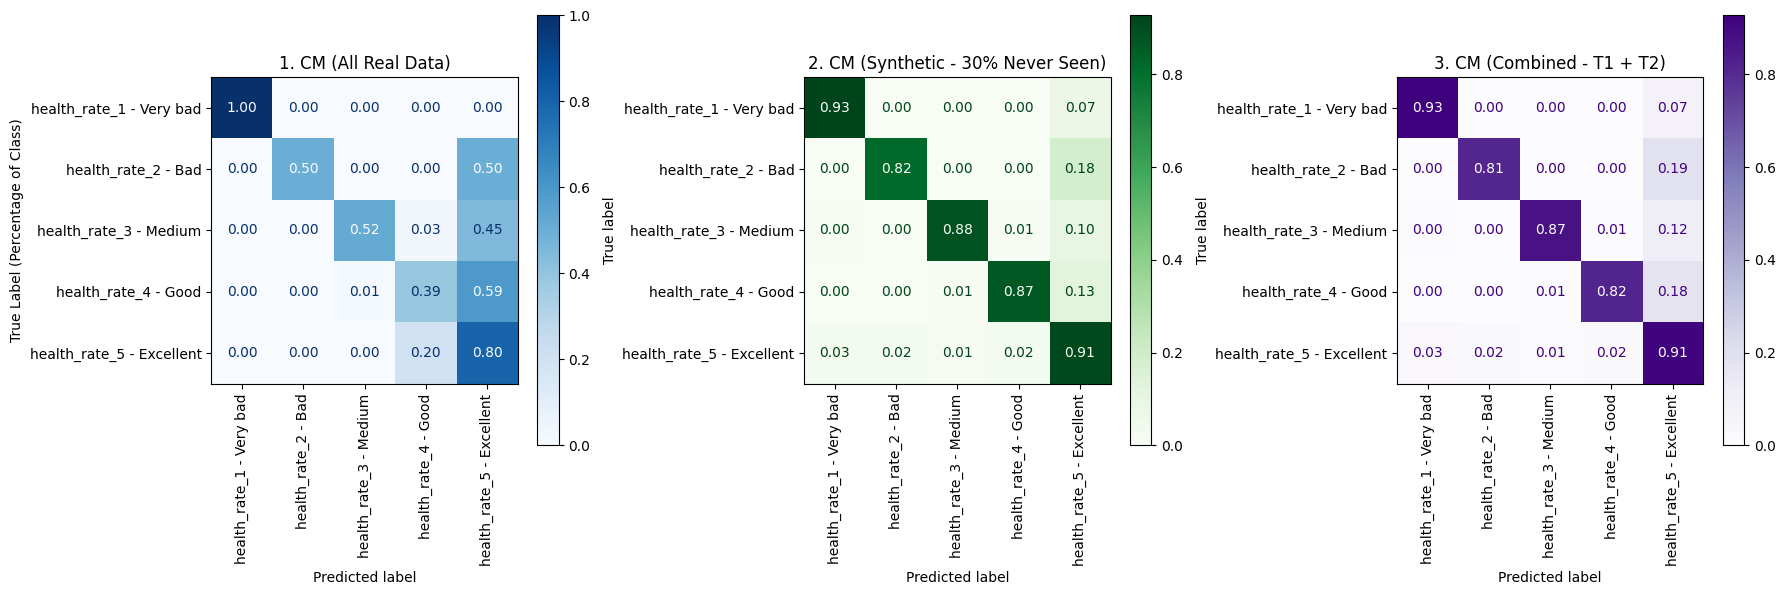

In [11]:
# 1. Instantiate the LabelEncoder
le = LabelEncoder()

y_train = le.fit_transform(y_train_df)
y_test_real_all = le.transform(y_test_real_all_df)

num_classes = len(le.classes_)

#target_columns_classes = [col.replace('health_rate_', '') for col in target_columns]

# 2. Fit it to the unique, sorted categories of your health_rate column
#    It's crucial to fit on the original data (df) to get the correct mapping.
#    Note: Use .astype(str) to handle potential numerical categories as strings correctly.
#clabels_to_fit = sorted(target_columns_classes)
#le.fit(clabels_to_fit)

# --- Triple Confusion Matrix Plotting ---
clabels = le.classes_

# Define the figure size for a good 1x3 layout.
plt.figure(figsize=(18, 6)) 

# Plot 1: All Real Data -> Left
plt.subplot(1, 3, 1)
cm_display_1 = ConfusionMatrixDisplay(confusion_matrix=conf_mat_real_all_norm, display_labels=clabels)
cm_display_1.plot(cmap=plt.cm.Blues, ax=plt.gca(), xticks_rotation='vertical', values_format='.2f')
plt.title('1. CM (All Real Data)')
plt.ylabel('True Label (Percentage of Class)') 

# Plot 2: Synthetic Data Sample -> Center
plt.subplot(1, 3, 2)
cm_display_2 = ConfusionMatrixDisplay(confusion_matrix=conf_mat_synth_norm, display_labels=clabels)
cm_display_2.plot(cmap=plt.cm.Greens, ax=plt.gca(), xticks_rotation='vertical', values_format='.2f')
plt.title('2. CM (Synthetic - 30% Never Seen)')

# Plot 3: Combined Data Sample -> Right
plt.subplot(1, 3, 3)
cm_display_3 = ConfusionMatrixDisplay(confusion_matrix=conf_mat_combined_norm, display_labels=clabels)
cm_display_3.plot(cmap=plt.cm.Purples, ax=plt.gca(), xticks_rotation='vertical', values_format='.2f')
plt.title('3. CM (Combined - T1 + T2)')

# Adjust layout for presentation
plt.tight_layout()

plt.show()